In [1]:
 # Importing Necessary Libraries
import cv2
import os
import shutil 
import math
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function for Image preprocessing
def processDataset(dataset_src, dataset_dest):
    # Create destination directory
    os.makedirs(dataset_dest, exist_ok=True)

    for folder in os.scandir(dataset_dest):
        for index, file in enumerate(os.scandir(folder), start=1):
            filename = f'img_{folder.name}_{index}.jpg'
            img_src = file.path
            img_des = os.path.join(folder.path, filename)

            # Preprocess the Images
            cap = cv2.VideoCapture(img_src)
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(img_des, fourcc, 30.0, (256, 256))

            while cap.isOpened():
                ret, frame = cap.read()
                if ret:
                    frame = cv2.resize(frame, (256, 256), interpolation=cv2.INTER_AREA)
                    frame = cv2.copyMakeBorder(frame, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=0)
                    frame = cv2.GaussianBlur(frame, (5, 5), 0)
                    out.write(frame)
                else:
                    break

            cap.release()
            out.release()

            os.remove(img_src)

        # Find duplicated images and delete duplicates
        findDelDuplImg(folder, dataset_dest)

# Function to find and delete duplicated images
def findDelDuplImg(folder, dataset_dest):
    images = {}
    for file in os.scandir(folder):
        if file.is_file():
            with open(file.path, 'rb') as f:
                filehash = hash(f.read())
            if filehash in images:
                os.remove(file.path)
            else:
                images[filehash] = file.path
    return

# Source Location for Dataset
src = "C:/Users/Ayesha Thabassum/Desktop/ml-project/Dataset"
# Destination Location for Dataset
dest = "C:/Users/Ayesha Thabassum/Desktop/ml-project/Dataset_dest"
# Image preprocessing
processDataset(src, dest)


In [3]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;
    
path = "C:/Users/Ayesha Thabassum/Desktop/ml-project/Dataset"
DatasetSize = GetDatasetSize(path);
print(DatasetSize);

{'cancer': 85, 'non-cancer': 44, 'test': 2, 'train': 2, 'val': 2}


###  Split the Dataset such that we have 
* 70% for Train Data
* 15% for Validation Data
* 15% for Testing Data

In [5]:
def TrainValTestSplit(root_dir, classes_dir, val_ratio=0.15, test_ratio=0.15):
    for cls in classes_dir:
        # Creating Split Folders
        os.makedirs(os.path.join(root_dir, 'train', cls))
        os.makedirs(os.path.join(root_dir, 'val', cls))
        os.makedirs(os.path.join(root_dir, 'test', cls))

        # Folder to copy images from
        src = os.path.join(root_dir, cls)

        # Storing the Filenames
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        
        # Spliting the Files in the Given ratio
        split_idx1 = int(len(allFileNames) * (1 - (val_ratio + test_ratio)))
        split_idx2 = int(len(allFileNames) * (1 - test_ratio))

        train_FileNames = allFileNames[:split_idx1]
        val_FileNames = allFileNames[split_idx1:split_idx2]
        test_FileNames = allFileNames[split_idx2:]

        train_FileNames = [os.path.join(src, name) for name in train_FileNames]
        val_FileNames = [os.path.join(src, name) for name in val_FileNames]
        test_FileNames = [os.path.join(src, name) for name in test_FileNames]

        # Printing the Split Details
        print(cls.upper(), ':')
        print('Total images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, os.path.join(root_dir, 'train', cls))

        for name in val_FileNames:
            shutil.copy(name, os.path.join(root_dir, 'val', cls))

        for name in test_FileNames:
            shutil.copy(name, os.path.join(root_dir, 'test', cls))
        print()

# Performing Train / Validation / Test Split
root_dir = "C:/Users/Ayesha Thabassum/Desktop/ml-project/Dataset"  # Dataset Root Folder
classes_dir = ['cancer', 'non-cancer']  # Classes
TrainValTestSplit(root_dir, classes_dir)


CANCER :
Total images:  85
Training:  59
Validation:  13
Testing:  13

NON-CANCER :
Total images:  44
Training:  30
Validation:  7
Testing:  7



### Building Model 


In [6]:
# Importing Keras for Image Classification
import keras
from keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [7]:
# CNN Model 

model = Sequential() 

# Convolutional Layer with input shape (256,256,3)
model.add(Conv2D(filters=32, kernel_size= (3,3), activation= 'relu', input_shape=(256,256,3)) )

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']  )
 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 128)       7

### Preparing data using data generator 

In [8]:
# Expand the size of dataset with new transformed images from the original dataset using ImageDataGenerator.
train_datagen = image.ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2 , rescale = 1./255 , horizontal_flip=True)
val_datagen = image.ImageDataGenerator(rescale = 1./255)
test_datagen = image.ImageDataGenerator(rescale = 1./255)

In [12]:
train_data = train_datagen.flow_from_directory(directory="C:/Users/Ayesha Thabassum/Desktop/ml-project/Dataset/train", target_size=(256,256), batch_size=32, class_mode = 'binary')

Found 89 images belonging to 2 classes.


In [13]:
train_data.class_indices

{'cancer': 0, 'non-cancer': 1}

In [15]:
val_data = val_datagen.flow_from_directory(directory= "C:/Users/Ayesha Thabassum/Desktop/ml-project/Dataset/val", target_size=(256,256), batch_size=32, class_mode = 'binary')

Found 20 images belonging to 2 classes.


In [16]:
test_data = test_datagen.flow_from_directory(directory= "C:/Users/Ayesha Thabassum/Desktop/ml-project/Dataset/test", target_size=(256,256), batch_size=32, class_mode = 'binary')

Found 20 images belonging to 2 classes.


In [17]:
# Adding Model check point Callback
mc = ModelCheckpoint(filepath="oral_cancer_best_model.hdf5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto');
call_back = [ mc ];

In [19]:
# Fitting the Model
cnn = model.fit(train_data, 
                  steps_per_epoch = 2, 
                  epochs = 26, 
                  validation_data = val_data, 
                  validation_steps = 1,
                  callbacks = call_back )

Epoch 1/26
2/2 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.8906
Epoch 1: val_accuracy improved from 0.80000 to 0.85000, saving model to oral_cancer_best_model.hdf5
2/2 [==============================] - 11s 6s/step - loss: 0.3241 - accuracy: 0.8906 - val_loss: 0.5047 - val_accuracy: 0.8500
Epoch 2/26
2/2 [==============================] - ETA: 0s - loss: 0.2402 - accuracy: 0.9123
Epoch 2: val_accuracy did not improve from 0.85000
2/2 [==============================] - 9s 4s/step - loss: 0.2402 - accuracy: 0.9123 - val_loss: 0.4720 - val_accuracy: 0.8000
Epoch 3/26
2/2 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.8594
Epoch 3: val_accuracy did not improve from 0.85000
2/2 [==============================] - 10s 5s/step - loss: 0.3578 - accuracy: 0.8594 - val_loss: 0.4270 - val_accuracy: 0.8000
Epoch 4/26
2/2 [==============================] - ETA: 0s - loss: 0.3642 - accuracy: 0.8281
Epoch 4: val_accuracy did not improve from 0.85000

In [20]:
model.save("finalmodel/oral_cancer.h5")

In [ ]:
# Loading the Best Fit Model 
#model = load_model("./oral_cancer_best_model.hdf5")

### Model Accuracy


In [21]:
# Checking the Accuracy of the Model 
accuracy = model.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of the model is = {accuracy*100} %")

The accuracy of the model is = 94.9999988079071 %


In [22]:
h =  cnn.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

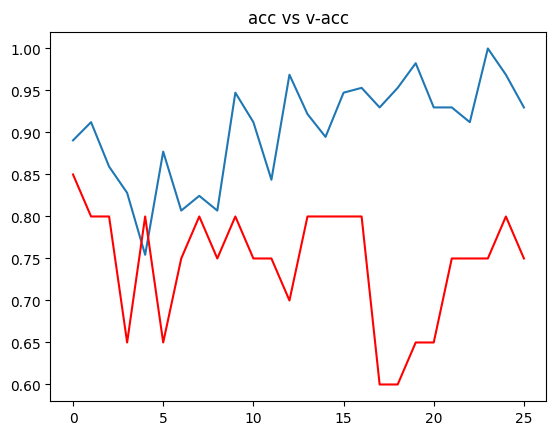

In [23]:
# Ploting Accuracy In Training Set & Validation Set
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

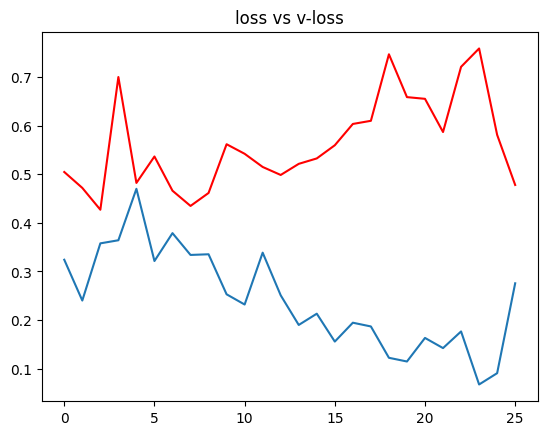

In [24]:
# Ploting Loss In Training Set & Validation Set
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

1/1 [==============================] - 0s 409ms/step
cancer


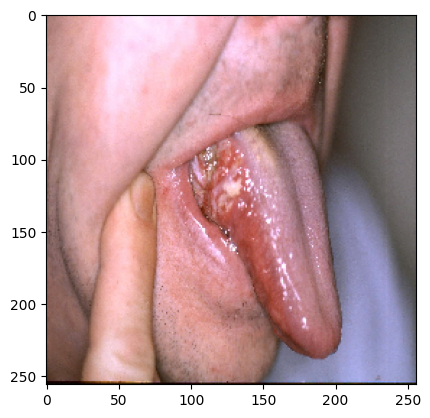

In [29]:
import keras.utils as ku
def cancerPrediction(path):
    # Loading Image
    img = ku.load_img(path, target_size=(256,256))
    # Normalizing Image
    norm_img = ku.img_to_array(img)/255
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    imgplot = plt.imshow(img)
    # Getting Predictions
    pred = (model.predict(input_arr_img) > 0.5).astype(int)[0][0]
    # Printing Model Prediction
    if pred == 0:
        print("cancer")
    else:
        print("non-cancer")
    
# Path for the image to get predictions    
path = "C:/Users/Ayesha Thabassum/Desktop/ml-project/Dataset/test/cancer/4.jpg"
cancerPrediction(path)

1/1 [==============================] - 0s 63ms/step
non-cancer


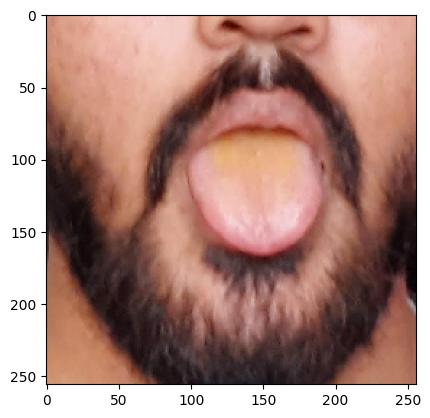

In [32]:
import keras.utils as ku
def cancerPrediction(path):
    # Loading Image
    img = ku.load_img(path, target_size=(256,256))
    # Normalizing Image
    norm_img = ku.img_to_array(img)/255
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    imgplot = plt.imshow(img)
    # Getting Predictions
    pred = (model.predict(input_arr_img) > 0.5).astype(int)[0][0]
    # Printing Model Prediction
    if pred == 0:
        print("cancer")
    else:
        print("non-cancer")
    
# Path for the image to get predictions    
path = "C:/Users/Ayesha Thabassum/Desktop/ml-project/Dataset/non-cancer/22.jpg"
cancerPrediction(path)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


FileNotFoundError: [Errno 2] No such file or directory: 'convnet.png'